In [28]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [29]:
# Wczytanie danych
file_path = "C:/Users/user/Downloads/snack_pack_dataset.csv"
df = pd.read_csv(file_path)

In [30]:
# Usuniecie brakujacych wartosci, jesli wystepuja
# df.dropna(inplace=True)

In [31]:
# Zamiana przecinkow na kropki w liczbach zmiennoprzecinkowych, jesli wystepuja
# df = df.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x

In [32]:
# Konwersja kolumn do odpowiednich typow
df["Kalorie"] = df["Kalorie"].astype(int)
df["Białko (g)"] = df["Białko (g)"].astype(float)
df["Tłuszcz (g)"] = df["Tłuszcz (g)"].astype(float)
df["Węglowodany (g)"] = df["Węglowodany (g)"].astype(int)
df["Cena ($)"] = df["Cena ($)"].astype(float)

In [33]:
# Parametry problemu plecakowego
budzet = 5.0  # Maksymalna kwota do wydania
n = len(df)

In [34]:
# Heurystyczne podejscie: sortowanie wedlug stosunku kalorii do ceny
df["Kalorie/Cena"] = df["Kalorie"] / df["Cena ($)"]
df_sorted = df.sort_values(by="Kalorie/Cena", ascending=False)

In [35]:
# Wybor przekasek w ramach budzetu
def heuristic_solution(df_sorted, budget):
    selected_items = []
    total_cost = 0
    total_calories = 0

    for _, row in df_sorted.iterrows():
        if total_cost + row["Cena ($)"] <= budget:
            selected_items.append(row["Nazwa"])
            total_cost += row["Cena ($)"]
            total_calories += row["Kalorie"]

    return selected_items, total_calories, total_cost

heuristic_result = heuristic_solution(df_sorted, budzet)
print("Heurystyczne rozwiązanie:", heuristic_result)

Heurystyczne rozwiązanie: (['Czekolada', 'Chipsy', 'Orzechy'], 1620, 4.7)


In [36]:
# Algorytm genetyczny
POPULATION_SIZE = 50
GENERATIONS = 100
MUTATION_RATE = 0.1

def fitness(individual):
    """ Oblicza sume kalorii dla danej kombinacji, sprawdzajac budzet """
    total_cost = sum(df["Cena ($)"][i] for i in range(n) if individual[i] == 1)
    total_calories = sum(df["Kalorie"][i] for i in range(n) if individual[i] == 1)
    
    return total_calories if total_cost <= budzet else 0  # rozwiazania przekraczajace budzet

def mutate(individual):
    """ Mutacja: losowa zmiana jednego bitu """
    i = random.randint(0, n - 1)
    individual[i] = 1 - individual[i]

def crossover(parent1, parent2):
    """ Krzyzowanie jednopunktowe """
    point = random.randint(1, n - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

In [37]:
# Inicjalizacja populacji
population = [[random.randint(0, 1) for _ in range(n)] for _ in range(POPULATION_SIZE)]

for generation in range(GENERATIONS):
    # Obliczenie funkcji przystosowania
    fitness_scores = [fitness(ind) for ind in population]
    
    # Selekcja rodzicow (ruletka)
    selected = random.choices(population, weights=fitness_scores, k=POPULATION_SIZE)
    
    # Tworzenie nowej populacji przez krzyzowanie i mutacje
    new_population = []
    for i in range(0, POPULATION_SIZE, 2):
        offspring1, offspring2 = crossover(selected[i], selected[i + 1])
        if random.random() < MUTATION_RATE:
            mutate(offspring1)
        if random.random() < MUTATION_RATE:
            mutate(offspring2)
        new_population.extend([offspring1, offspring2])
    
    population = new_population

In [38]:
# Najlepsze rozwiazanie z ostatniej generacji
best_solution = max(population, key=fitness)
best_items = [df["Nazwa"][i] for i in range(n) if best_solution[i] == 1]
best_calories = fitness(best_solution)
best_cost = sum(df["Cena ($)"][i] for i in range(n) if best_solution[i] == 1)

print("\nAlgorytm genetyczny - najlepsze rozwiązanie:")
print("Wybrane przekąski:", best_items)
print("Suma kalorii:", best_calories)
print("Łączny koszt:", best_cost)


Algorytm genetyczny - najlepsze rozwiązanie:
Wybrane przekąski: ['Chipsy', 'Czekolada', 'Jabłko', 'Kefir']
Suma kalorii: 1222
Łączny koszt: 4.6


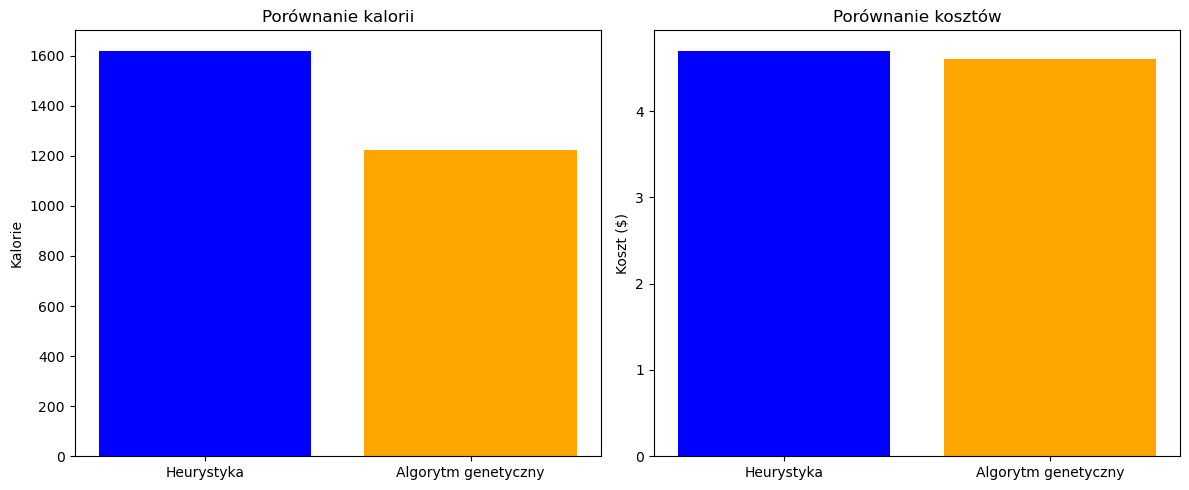

In [39]:
# 1. Porownanie heurystyki i algorytmu genetycznego
methods = ['Heurystyka', 'Algorytm genetyczny']
calories = [heuristic_result[1], best_calories]
costs = [heuristic_result[2], best_cost]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Wykres kalorii
ax1.bar(methods, calories, color=['blue', 'orange'])
ax1.set_title('Porównanie kalorii')
ax1.set_ylabel('Kalorie')

# Wykres kosztow
ax2.bar(methods, costs, color=['blue', 'orange'])
ax2.set_title('Porównanie kosztów')
ax2.set_ylabel('Koszt ($)')

plt.tight_layout()
plt.show()

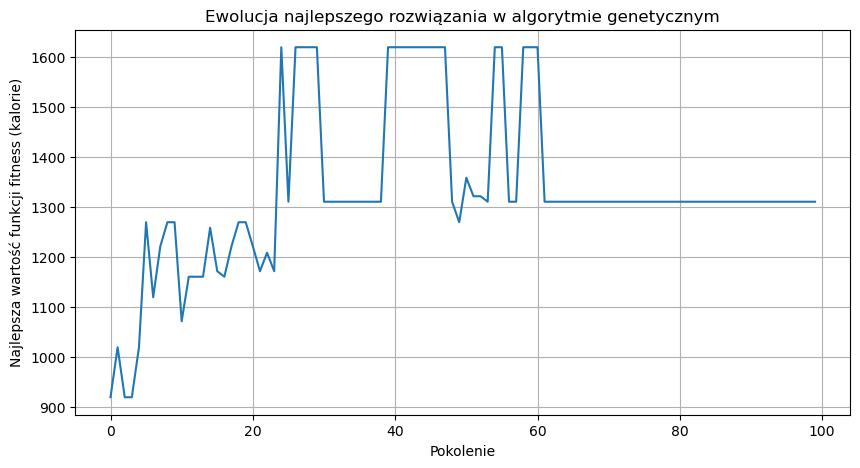

In [40]:
# 2. Sledzenie ewolucji najlepszego rozwiazania w algorytmie genetycznym
# Modyfikujemy algorytm genetyczny, aby zapisywal historie
best_fitness_history = []

population = [[random.randint(0, 1) for _ in range(n)] for _ in range(POPULATION_SIZE)]

for generation in range(GENERATIONS):
    fitness_scores = [fitness(ind) for ind in population]
    best_fitness = max(fitness_scores)
    best_fitness_history.append(best_fitness)
    
    selected = random.choices(population, weights=fitness_scores, k=POPULATION_SIZE)
    new_population = []
    for i in range(0, POPULATION_SIZE, 2):
        offspring1, offspring2 = crossover(selected[i], selected[i + 1])
        if random.random() < MUTATION_RATE:
            mutate(offspring1)
        if random.random() < MUTATION_RATE:
            mutate(offspring2)
        new_population.extend([offspring1, offspring2])
    population = new_population

# Wykres ewolucji najlepszego rozwiazania
plt.figure(figsize=(10, 5))
plt.plot(best_fitness_history)
plt.title('Ewolucja najlepszego rozwiązania w algorytmie genetycznym')
plt.xlabel('Pokolenie')
plt.ylabel('Najlepsza wartość funkcji fitness (kalorie)')
plt.grid(True)
plt.show()